# HW2

**Author**: Ben Peloquin

**Collaborator**: Marc Harrison
    
**Date**: 20190507

In [135]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy.stats import ttest_ind, f_oneway
import seaborn as sns
import sys
import tqdm

from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV

module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path)
print(module_path)
from psych253.cross_validation import get_splits, train_and_test_scikit_classifier
plt.style.use('ggplot')

%matplotlib inline

/Users/benpeloquin/Desktop/PHD/Classes/Psych253


# Setup

In [2]:
data_fp = "../data/ventral_neural_data.hdf5"
d_ventral = h5py.File(data_fp, 'r')
print(d_ventral.keys())

[u'image_meta', u'images', u'neural_meta', u'time_averaged', u'time_averaged_trial_averaged', u'time_binned', u'time_binned_trial_averaged']


In [3]:
chabo_mask = d_ventral['neural_meta']['ANIMAL_INFO'][:] == 'Chabo'
tito_mask = d_ventral['neural_meta']['ANIMAL_INFO'][:] == 'Tito'

chabo_idxs = np.array(range(d_ventral['neural_meta']['ANIMAL_INFO'].shape[0]))[chabo_mask]
tito_idxs = np.array(range(d_ventral['neural_meta']['ANIMAL_INFO'].shape[0]))[tito_mask]

## Question 1: Regression in neural data

In [4]:
v4_idxs = d_ventral['neural_meta']['V4_NEURONS'][:]
it_idxs = d_ventral['neural_meta']['IT_NEURONS'][:]
print(d_ventral['image_meta'].keys())
d_all_sizes = d_ventral['image_meta']['size'][:]

[u'category', u'object_name', u'rotation_xy', u'rotation_xz', u'rotation_yz', u'size', u'translation_y', u'translation_z', u'variation_level']


In [5]:
# Features are neurons, prediction is size
X_v4 = d_ventral['time_averaged_trial_averaged'][:, v4_idxs[:-40]]  # Remove bad last 40
X_it = d_ventral['time_averaged_trial_averaged'][:, it_idxs]
datas = [('V4', X_v4), ('IT', X_it)]
y = d_all_sizes[:]
assert(map(lambda x: x[1].shape[0]==y.shape[0], datas))

### Question 1.1: Size regression from neural responses

#### 1.1.1.a OLS regression

In [103]:
def get_random_sample(X, size):
    """Helper for IT neurons"""
    sample_idxs = random.sample(range(X.shape[len(X.shape)-1]), k=size)
    return X[:, sample_idxs]

def get_split_idxs(total, train_prop=0.8, max_size=None):
    """Return train and test split of indices.
    
    Parameters
    ----------
    total: int
        Number indices.
    train_prob: float [Default: 0.8]
        Train size.
    max_size: int [Default: None]
        Limit max size (for sub-sampling)
    
    Returns
    -------
    tuple
        Train and test indices.

    """
    all_idxs = [i for i in range(total)]
    np.random.shuffle(all_idxs)
    if max_size is not None and max_size < total:
        all_idxs = all_idxs[:max_size]
    Xs = set(all_idxs[:int(len(all_idxs)*train_prop)])
    ys = set(all_idxs) - Xs
    return np.array(list(Xs)), np.array(list(ys))

def r_squared(predicted, actual):
    """The "rsquared" metric
    """
    a_mean = actual.mean()
    num = np.linalg.norm(actual - predicted)**2
    denom = np.linalg.norm(actual - a_mean)**2
    return 1 - num / denom

def run_model(model_klass, X_train, y_train, X_test, y_test, eval_fn=r_squared):
    """Run model helper.
    
    Parameters
    ----------
    model_klass: sklearn model object
        Sklearn model.
    X_train: np.array (num_examples, num_features)
        Train features.
    y_train: np.array (num_examples, )
        Train supervision.
    X_test: np.array (num_examples, num_features)
        Test features.
    y_test: np.array (num_examples, )
        Test supervision.
        
    Returns
    -------
    tuple
        Tuple of (float, float, sklearn object)
    
    """
    model = model_klass.fit(X_train, y_train)
    # Preds
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_preds = train_preds.squeeze()
    test_preds = test_preds.squeeze()
    train_loss = eval_fn(train_preds, y_train)
    test_loss = eval_fn(test_preds, y_test)
    return train_loss, test_loss, model

In [104]:
n_sims = 20
max_size = 88
train_prop = 0.8

In [105]:
d_results = []
for sim_idx in tqdm.tqdm(range(n_sims)):
    train_idxs, test_idxs = current_indices = \
            get_split_idxs(len(y), train_prop)
    # Note (BP): Here we sub-sample IT to have same 
    # size (88) as V4 with bad ones removed...
    X_it_partial = get_random_sample(X_it, size=max_size)
    datas.append(("IT_partial", X_it_partial))
    for roi, X in datas:
        # Partition into train and test
        X_train = X[train_idxs, :]
        y_train = y[train_idxs]
        X_test = X[test_idxs, :]
        y_test = y[test_idxs]

        # Fit model
        train_perf, test_perf, _ = \
            run_model(LinearRegression(), X_train, y_train, X_test, y_test)
        
        d_results.append({
            "sim_idx": sim_idx,
            "roi": roi,
            "train_r2": train_perf,
            "test_r2": test_perf
        })

df_results = pd.DataFrame(d_results)

100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


In [106]:
df_results \
    .groupby(['roi'])['test_r2'] \
    .aggregate({np.mean, np.std}) \
    .reset_index()

,roi,mean,std
0,IT,0.458634,2.693298e-02
1,IT_partial,0.417398,2.893860e-02
2,V4,1.000000,2.629900e-12


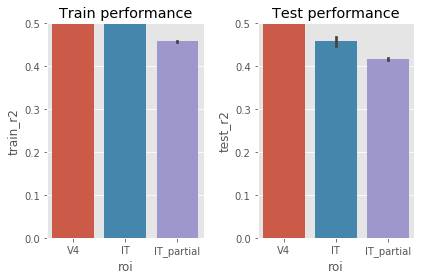

In [107]:
plt.subplot(121)
sns.barplot(x='roi', y='train_r2', ci=95, data=df_results)
plt.ylim(0, 0.5)
plt.title("Train performance")
plt.subplot(122)
sns.barplot(x='roi', y='test_r2', ci=95, data=df_results)
plt.ylim(0, 0.5)
plt.title("Test performance")
plt.tight_layout()

Let's run a t-test between the sub-sampled IT and V4

In [108]:
a = df_results[df_results['roi']=='V4'].test_r2
b = df_results[df_results['roi']=='IT_partial'].test_r2
ttest_ind(a, b)

Ttest_indResult(statistic=89.99852484932899, pvalue=0.0)

Comparing average $r^2$ between V4 and subsampled IT we see a significant difference (IT is higher).

#### 1.1.1.b  Ridge regression

In [109]:
n_sims = 30
max_size = 88
train_prop = 0.8
alphas = [1e-7, 1e-5, 1e-3, 1e-2, 1e-1, 1, 10, 100]
models = [("ridge_{}".format(alpha), Ridge(alpha=alpha)) for alpha in alphas]
# Ordinary least squares
models.append(("ols", LinearRegression()))
# Ridge CV
models.append(("ridge_cv", RidgeCV(alphas=alphas)))

In [110]:
d_results = []
for sim_idx in tqdm.tqdm(range(n_sims)):
    train_idxs, test_idxs = current_indices = \
            get_split_idxs(len(y), train_prop)
    X_it_partial = get_random_sample(X_it, size=max_size)
    datas.append(("IT_partial", X_it_partial))
    for roi, X in datas:
        # Partition into train and test
        X_train = X[train_idxs, :]
        y_train = y[train_idxs]
        X_test = X[test_idxs, :]
        y_test = y[test_idxs]
        for model_nam, model in models:
            # Fit model
            train_perf, test_perf, _ = \
                run_model(model, X_train, y_train, X_test, y_test)

            d_results.append({
                "sim_idx": sim_idx,
                "model_name": model_nam,
                "roi": roi,
                "train_r2": train_perf,
                "test_r2": test_perf,
                "model_meta": model.alpha_ if model_nam == "ridge_cv" else None
            })

df_results = pd.DataFrame(d_results)

  0%|          | 0/30 [00:00<?, ?it/s]Exception KeyError: KeyError(<weakref at 0x1a2dbaa8e8; to 'tqdm' at 0x1a1ff4b190>,) in <bound method tqdm.__del__ of   0%|          | 0/30 [00:03<?, ?it/s]> ignored


KeyboardInterrupt: 

In [26]:
d_best = []
for roi, group in (df_results \
    .groupby(["model_name", "roi"])[["test_r2"]] \
    .aggregate({np.mean}) \
    .reset_index() \
    .groupby("roi")):
    best_idx = group['test_r2'].idxmax().values[0]
    r2 = group[group.index==best_idx].test_r2.values[0][0]
    model_name_ = group[group.index==best_idx].model_name.values[0]
    d_best.append({
        "roi": roi,
        "model": model_name_,
        "r2": r2
    })
df_best = pd.DataFrame(d_best)

In [27]:
df_best

,model,r2,roi
0,ridge_100,0.372140,IT
1,ridge_10,0.313365,IT_partial
2,ridge_100,0.137637,V4


In [28]:
best_models = zip(df_best.roi.values, df_best.model.values)
best_models

[('IT', 'ridge_100'), ('IT_partial', 'ridge_10'), ('V4', 'ridge_100')]

In [29]:
# Filter best models
df_bests = pd.concat(
    [df_results[(df_results.roi == roi) & (df_results.model_name==model)] for roi, model in best_models])

In [30]:
df_bests["best_model_for_roi"] = \
    df_bests.apply(lambda x: "{}_{}".format(x["roi"], x["model_name"]), axis=1)

Text(0.5,1,'Best model by ROI')

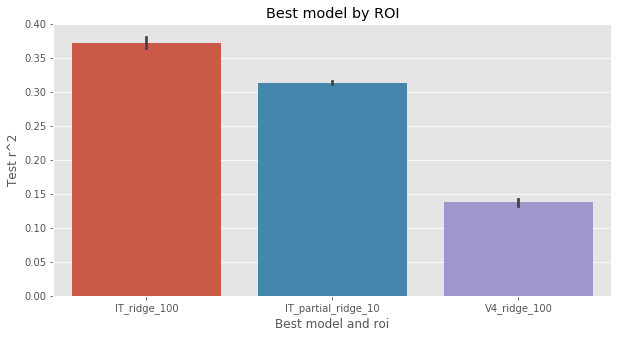

In [31]:
plt.figure(figsize=(10, 5))
sns.barplot(x="best_model_for_roi", y="test_r2", ci=95, data=df_bests)
plt.xlabel("Best model and roi")
plt.ylabel("Test r^2")
plt.title("Best model by ROI")

#### 1.1.1.c  Ridge regression with RidgeCV

Let's look at the alpha value found by RidgeCV in our runs above...

In [63]:
df_results[~df_results['model_meta'].isnull()] \
    .groupby(['roi', 'model_meta'])[['test_r2']] \
    .aggregate({np.mean, np.std, 'count'}) \
    .reset_index()[['roi', 'model_meta', 'test_r2']]

roi model_meta test_r2                    
                           count      mean       std
0          IT      100.0      30  0.372140  0.023674
1  IT_partial       10.0     946  0.312394  0.030657
2  IT_partial      100.0     119  0.318450  0.026844
3          V4       10.0       1  0.106466       NaN
4          V4      100.0      29  0.138325  0.015176

Yes, we basically have the exact same outcome as explicitly running grid search over alpha values.

### Question 1.1.2: Predicting neural responses from neural responses

In [111]:
chabo_v4_idxs = set(v4_idxs) & set(chabo_idxs)
tito_v4_idxs = set(v4_idxs) & set(tito_idxs[:-40])

# Only good v4 from both animal
X_chabo_v4 = d_ventral['time_averaged_trial_averaged'][:, chabo_v4_idxs]
X_tito_v4 = d_ventral['time_averaged_trial_averaged'][:, tito_v4_idxs] 

Let's predict `tito` from `chabo`.

In [122]:
n_sims = 30
train_prob = 0.8
max_size = None
alphas = [1e-7, 1e-5, 1e-3, 1e-2, 1e-1, 1, 10, 100]
n_components = [2**x for x in range(1, 7)]
models = [("ridge", RidgeCV(alphas=alphas)), ("lasso", LassoCV(alphas=alphas))]
pls_models = [("pls_{}".format(nc), PLSRegression(n_components=nc)) for nc in n_components]
models.extend(pls_models)

In [123]:
X.shape
y.shape
temp_m = PLSRegression().fit(X, y)
r_squared(temp_m.predict(X).squeeze(), y)


0.35192485287492736

In [124]:
import warnings
warnings.filterwarnings('ignore')

y = X_tito_v4[:, 0]
X = X_chabo_v4
d_results3 = []
for sim_idx in tqdm.tqdm(range(n_sims)):
    train_idxs, test_idxs = current_indices = \
            get_split_idxs(len(y), train_prop)
    for model_name, model in models:
        # Partition into train and test
        X_train = X[train_idxs, :]
        y_train = y[train_idxs]
        X_test = X[test_idxs, :]
        y_test = y[test_idxs]
        train_perf, test_perf, model_ = \
            run_model(model, X_train, y_train, X_test, y_test)

        d_results3.append({
            "sim_idx": sim_idx,
            "model_name": model_name,
            "hyperparam": model_.alpha_ \
                if model_name[:3] != 'pls' \
                else model_name.split("_")[-1],
            "train_r2": train_perf,
            "test_r2": test_perf
        })

df_results3 = pd.DataFrame(d_results3)

100%|██████████| 30/30 [00:06<00:00,  4.49it/s]


In [125]:
df_results3 \
    .groupby(["model_name", "hyperparam"])["test_r2"] \
    .aggregate({np.mean, np.std, "count"}) \
    .reset_index()

,model_name,hyperparam,count,mean,std
0,lasso,1e-05,4,0.410786,0.029130
1,lasso,0.001,25,0.401317,0.016874
2,lasso,0.01,1,0.353615,NaN
3,pls_16,16,30,0.408725,0.019135
4,pls_2,2,30,0.346155,0.021519
5,pls_32,32,30,0.408674,0.019122
6,pls_4,4,30,0.391469,0.017771
7,pls_64,64,30,0.408674,0.019122
8,pls_8,8,30,0.407904,0.019004
9,ridge,10,30,0.409276,0.018931


* Lasso

The last time we ran this `1e-3` had the second highest mean value, but was most often found to have the best r^2 value. So we're going to set the best Lasso to `1e-3`.
* Ridge

Clearly it's `10` for Ridge.

* PLS

It's hard to differentiate for the various `n_components` as they're all quite close. If we just choose the argmax for r^2 we'd go with `n_components=16`.

In [126]:
best_ridge = Ridge(alpha=10)
best_lasso = Lasso(alpha=1e-3)
best_pls = PLSRegression(n_components=16)
models = [("ridge", best_ridge), ("lasso", best_lasso), ("pls", best_pls)]

In [128]:
n_sims = 100
train_prop = 0.8
d_bests = []
for sim_idx in tqdm.tqdm(range(n_sims)):
    train_idxs, test_idxs = current_indices = \
            get_split_idxs(len(y), train_prop)
    for model_name, model in models:
        # Partition into train and test
        X_train = X[train_idxs, :]
        y_train = y[train_idxs]
        X_test = X[test_idxs, :]
        y_test = y[test_idxs]
        train_perf, test_perf, model_ = \
            run_model(model, X_train, y_train, X_test, y_test)

        d_bests.append({
            "sim_idx": sim_idx,
            "model_name": model_name,
            "train_r2": train_perf,
            "test_r2": test_perf
        })
df_bests = pd.DataFrame(d_bests)

100%|██████████| 100/100 [00:03<00:00, 23.19it/s]


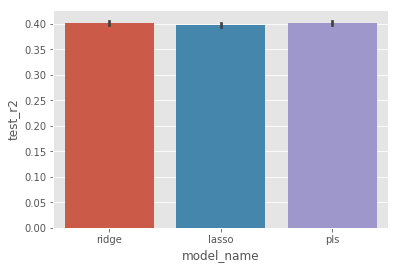

In [130]:
sns.barplot(x='model_name', y='test_r2', ci=95, data=df_bests)

In [133]:
df_bests \
    .groupby('model_name')[['test_r2']] \
    .aggregate({np.mean, np.std})

test_r2          
                mean       std
model_name                    
lasso       0.397518  0.018949
pls         0.401387  0.020286
ridge       0.402317  0.020028

Ridge appears to win out, but there really appear indistinguishable. Let's run a one-way anova to test for a significant difference between models...

In [136]:
f_oneway(df_bests[df_bests['model_name']=='lasso'].test_r2, 
         df_bests[df_bests['model_name']=='ridge'].test_r2,
         df_bests[df_bests['model_name']=='pls'].test_r2)

F_onewayResult(statistic=1.658233368747138, pvalue=0.19223372249092782)

Doesn't appear to be a significant difference.

## Question 1.2: Regression in self-regulation ontology data

#### 1.2.1 Data explanation

#### 1.2.2 Reliability of task and survey measures